## Import libraries

In [11]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Loading pretrained MobileNetV2

In [12]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

## Preprocessing image for MobileNetV2

In [13]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Loading Image from wikimedia

In [14]:
image_path = tf.keras.utils.get_file('macaw.png',
    'https://images.unsplash.com/photo-1612024782955-49fae79e42bb?q=80&w=687&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


## Loaded Image Plot

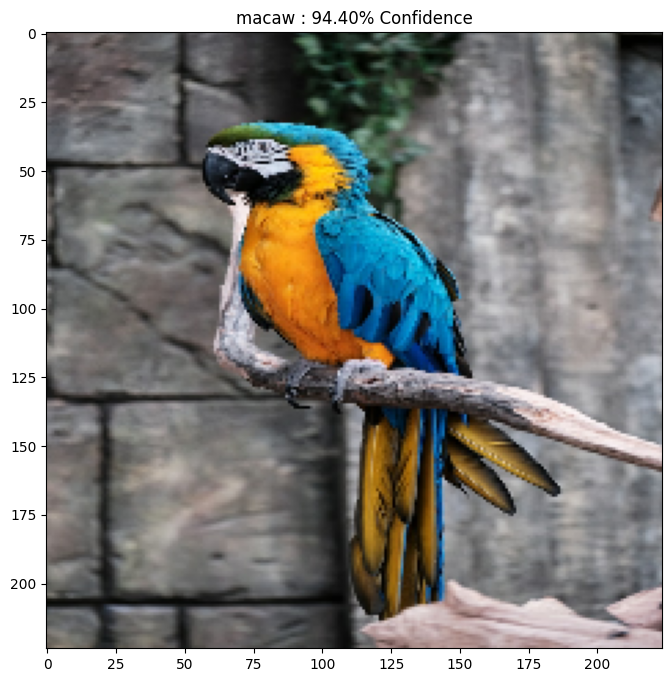

In [15]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

### Creating adversial image

In [16]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

### The resulting perturbations can also be visualised.

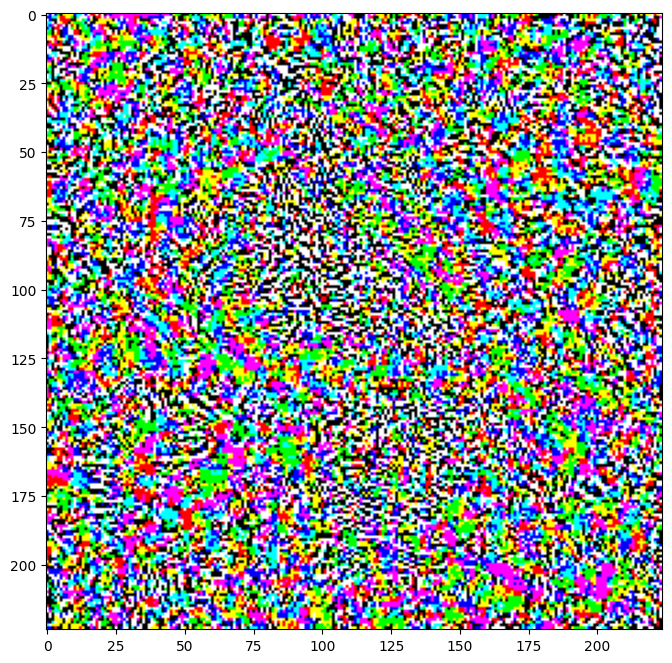

In [17]:
# Get the input label of the image.
macaw_index = 88
label = tf.one_hot(macaw_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

## With Different Values of Epsilon

In [18]:
def display_images_grid(image_desc_list):
    """
    Display up to 9 images in a 3x3 grid.
    image_desc_list: list of (image_tensor, description)
    """
    num_images = len(image_desc_list)
    plt.figure(figsize=(10, 8))

    for i, (image, description) in enumerate(image_desc_list):
        pred = pretrained_model.predict(image)
        _, label, confidence = get_imagenet_label(pred)

        plt.subplot(2, 2, i + 1)
        plt.imshow(image[0] * 0.5 + 0.5)  # unnormalize
        plt.title(f"{description}\n{label}: {confidence*100:.2f}%", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


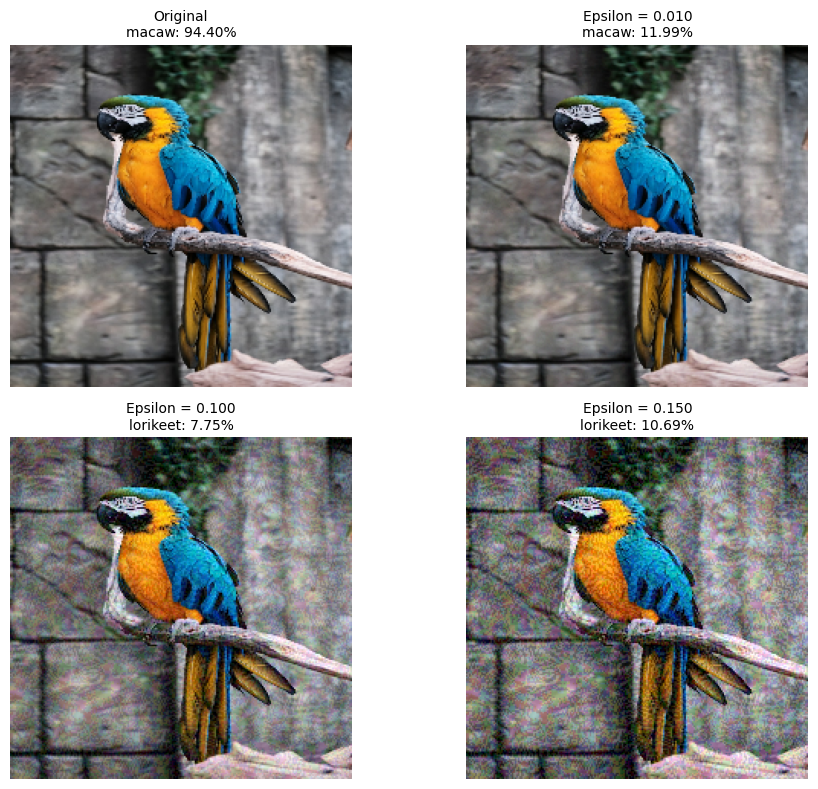

In [19]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Original')
                for eps in epsilons]

images = []

for i, eps in enumerate(epsilons):
    adv_x = image + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    images.append((adv_x, descriptions[i]))

display_images_grid(images)


## Adding some Gaussian noise to the image and Running attack again

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


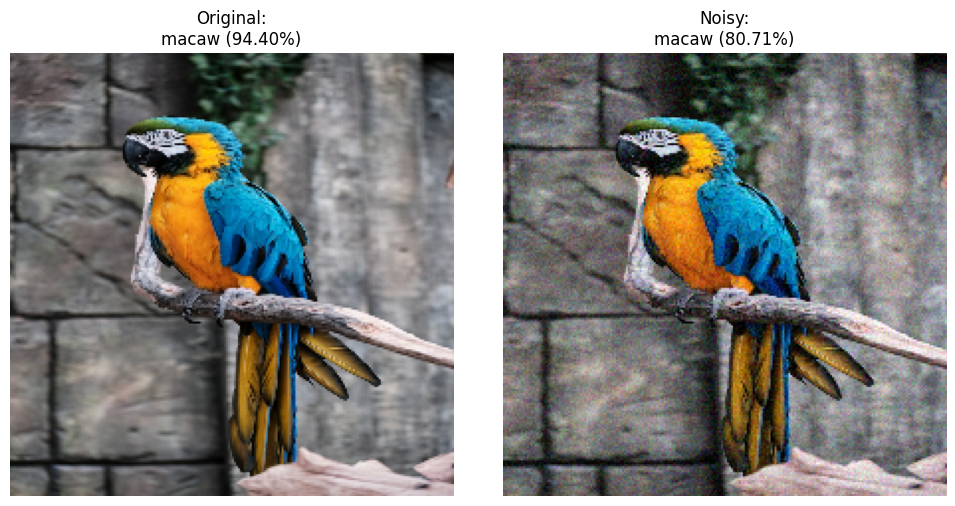

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


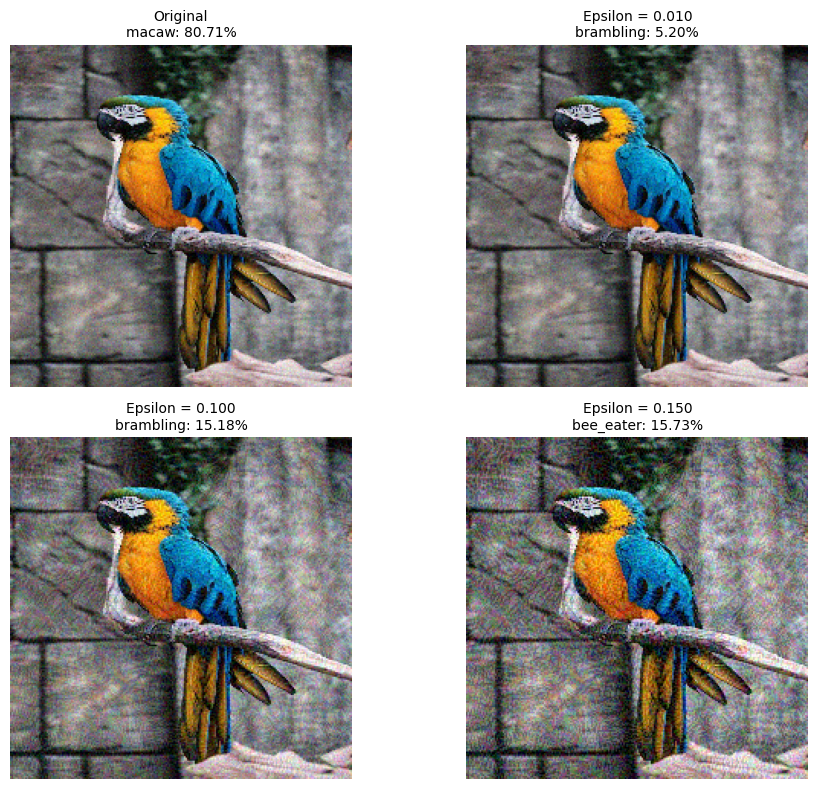

In [20]:
# Add Gaussian noise to original image
def add_gaussian_noise(image, mean=0.0, stddev=0.1):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=tf.float32)
    return tf.clip_by_value(image + noise, -1.0, 1.0)

noisy_image = add_gaussian_noise(image, stddev=0.1)

# Get prediction for original and noisy image
original_probs = pretrained_model.predict(image)
_, original_label, original_confidence = get_imagenet_label(original_probs)

noisy_probs = pretrained_model.predict(noisy_image)
_, noisy_label, noisy_confidence = get_imagenet_label(noisy_probs)

# Display both
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image[0] * 0.5 + 0.5)
plt.title(f"Original:\n{original_label} ({original_confidence * 100:.2f}%)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_image[0] * 0.5 + 0.5)
plt.title(f"Noisy:\n{noisy_label} ({noisy_confidence * 100:.2f}%)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Create adversarial pattern on noisy image
macaw_index = 88
label = tf.one_hot(macaw_index, original_probs.shape[-1])
label = tf.reshape(label, (1, original_probs.shape[-1]))

perturbations = create_adversarial_pattern(noisy_image, label)

epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Original') for eps in epsilons]

images = []
for i, eps in enumerate(epsilons):
    adv_x = noisy_image + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    images.append((adv_x, descriptions[i]))

display_images_grid(images)
